In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models, layers, callbacks

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

In [4]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nAccuracy is greater than 98% so terminating training!")
      self.model.stop_training = True

callbacks = myCallback()

In [5]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    'Animal-Image-Classifier/animal dataset/train',
    image_size=(256,256),
    shuffle=True,
    batch_size=32
)

Found 2400 files belonging to 3 classes.


In [6]:
# 800 x 3 = 2400 images, 1 of each class

In [7]:
len(train_df)

75

75 batches. Each batch has 32 images. 32 x 75 = 2400 images

In [8]:
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    'Animal-Image-Classifier/animal dataset/test',
    image_size=(256,256),
    shuffle=True,
    batch_size=32
)

val_df = tf.keras.preprocessing.image_dataset_from_directory(
    'Animal-Image-Classifier/animal dataset/val',
    image_size=(256,256),
    shuffle=True,
    batch_size=32
)


Found 300 files belonging to 3 classes.
Found 300 files belonging to 3 classes.


In [9]:
len(test_df), len(val_df)

(10, 10)

### DATA EXPLORATION

In [10]:
classes = train_df.class_names
classes

['cats', 'dogs', 'panda']

In [11]:
batch1 = train_df.take(1)

In [12]:
for image, label in batch1:
    print(image.shape)
    print(label.numpy())

(32, 256, 256, 3)
[0 0 2 1 2 0 2 2 0 2 1 0 0 0 0 1 2 0 0 1 1 1 0 2 2 1 0 0 0 2 2 2]


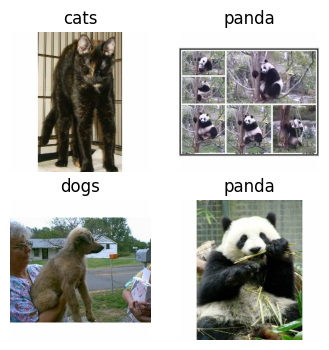

In [16]:
plt.figure(figsize=(4,4))
for image,label in train_df.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1),
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(classes[label[i]])
        plt.axis('off')

In [17]:
# CACHING & PREFETCHING TO MAKE THE PIPELINE HIGH PERFORMANT :

train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
# Rescaling & Resizing data for testing and smoother training.
scale = tf.keras.Sequential([
    layers.Resizing(256,256),
    layers.Rescaling(1.0/255)
])

In [19]:
# Adding custom images using data augmentation technique for better accuracy.

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

### MODEL BUILDING

In [20]:
model = models.Sequential([
    layers.InputLayer(input_shape=(256,256,3)),
    scale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [21]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
epo=model.fit(
    train_df,
    epochs=50,
    verbose=1,
    batch_size=32,
    validation_data=val_df,
    callbacks=[callbacks]
)

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 76ms/step - accuracy: 0.4226 - loss: 1.0341 - val_accuracy: 0.5900 - val_loss: 0.8689
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.5662 - loss: 0.8221 - val_accuracy: 0.6133 - val_loss: 0.7799
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - accuracy: 0.6144 - loss: 0.7680 - val_accuracy: 0.5900 - val_loss: 0.8003
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.5795 - loss: 0.8292 - val_accuracy: 0.6100 - val_loss: 0.7789
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - accuracy: 0.6025 - loss: 0.7431 - val_accuracy: 0.7100 - val_loss: 0.7037
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - accuracy: 0.6565 - loss: 0.6985 - val_accuracy: 0.6733 - val_loss: 0.7636
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - accuracy: 0.6422 - loss: 0.6919 - val_accuracy: 0.7033 - val_loss: 0.7164
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.6821 - loss: 0.6439 - val_accuracy: 0.69

In [24]:
score=model.evaluate(test_df)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7979 - loss: 0.4746


In [25]:
epo.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [26]:
loss = epo.history["loss"]
val_loss = epo.history["val_loss"]
acc = epo.history["accuracy"]
val_acc = epo.history["val_accuracy"]

In [27]:
len(acc), len(val_acc)

(50, 50)

Text(0.5, 1.0, 'Training & Validation Accuracy')

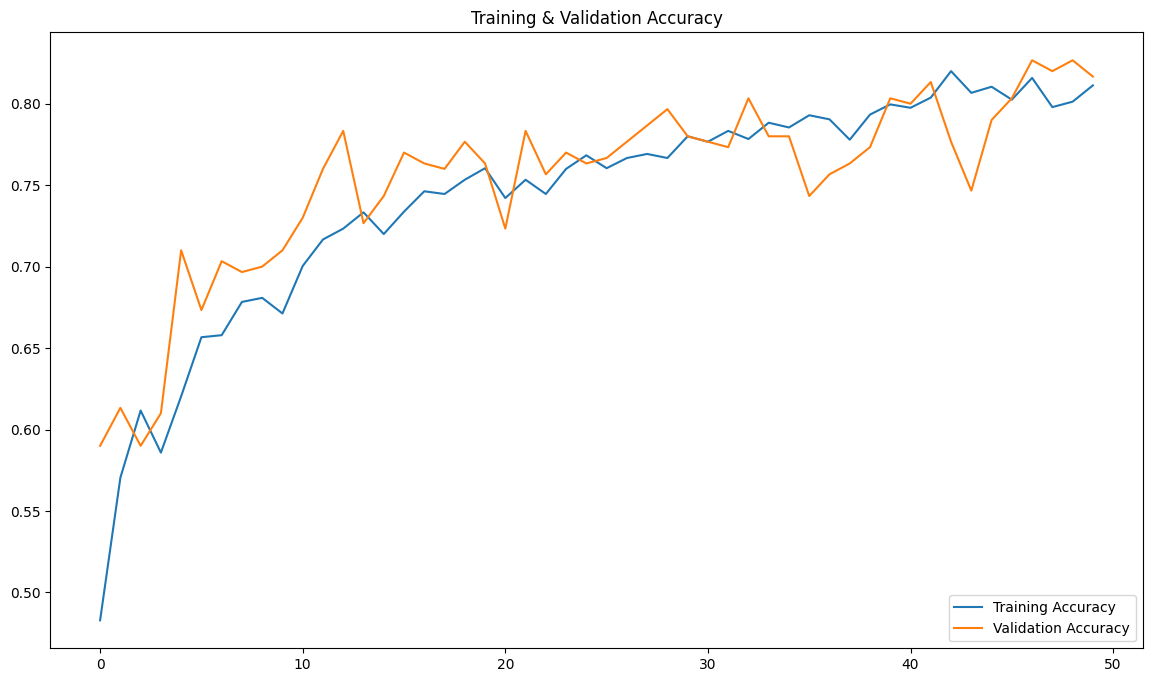

In [28]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc="lower right")
plt.title('Training & Validation Accuracy')

Text(0.5, 1.0, 'Training & Validation Loss')

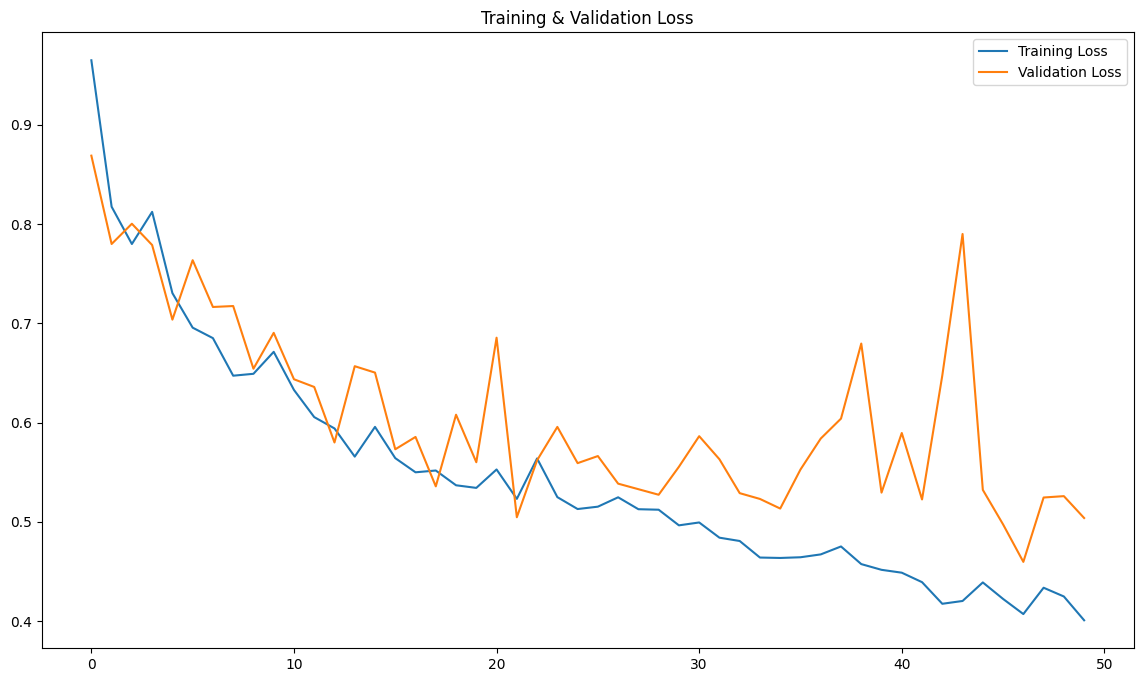

In [29]:
plt.figure(figsize=(31,8))
plt.subplot(1,2,1)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc="upper right")
plt.title('Training & Validation Loss')

### testing

In [30]:
batch1 =test_df.take(1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step

True : panda
Predicted : panda


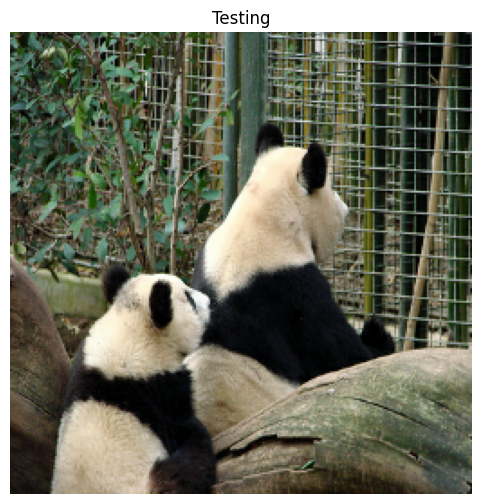

In [31]:
plt.figure(figsize=(6,6))
for img, clf in batch1:
    random_img = img[0].numpy().astype('uint8')
    typ = clf[0].numpy()

    plt.imshow(random_img)
    plt.axis('off')
    plt.title("Testing")
    prediction = model.predict(img)

    print("\nTrue :",classes[typ])
    print("Predicted :",classes[np.argmax(prediction[0])])

In [32]:
def pred(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = tf.expand_dims(array,0)

    prediction = model.predict(array)

    clf = classes[np.argmax(prediction[0])]
    conf = round(100 * (np.max(prediction[0])), 2)
    return clf, conf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


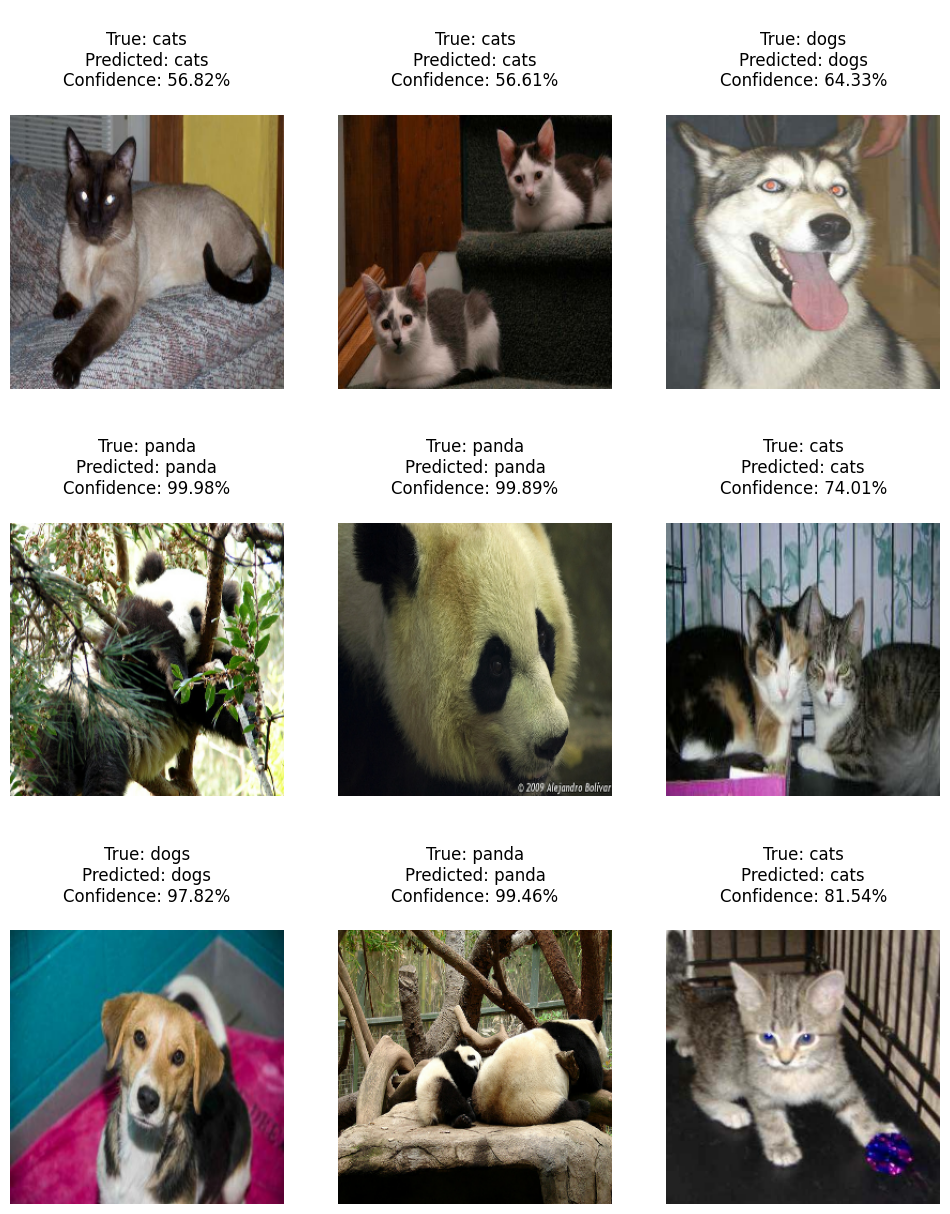

In [37]:
plt.figure(figsize=(12,15))
for img, lab in batch1:
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(img[i].numpy().astype('uint8'))

        prediction, confidence = pred(img[i].numpy())
        true = classes[lab[i]]
        plt.title(f"\nTrue: {true}\nPredicted: {prediction}\nConfidence: {confidence}%\n")
        plt.axis('off')

In [ ]:
model.save("models/model.keras")